In [1]:
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt
%matplotlib inline

### Reading companies data

In [2]:
with open('company_scraping_raw.json') as f:
    data = f.read()

#### Cleaned Data using regex

* `\[\d+\]`
* `"("` to `""`
* `")"` to `""`
* `"CEO"` to `""`
* `"(CEO)"` to `""`
* `"President"` to `""`
* `Interim` to ` `
* `"&"` to `""`
* `","` to `""`
* `"Independent"` to `""`
* `[,` to `[`
* `, ]` to `]`
* `\\u00a0` to ` `
* `\(\d.*\)` to ` `
* `Full List` to ` `
* `, "" ,` to `,`
* `,"` to `"`
* `,",` to `",`
* `(",` to `",`
* `\d+ years ago` to ` `
* `"; "` to `""`
* `"See Below"` to `""`
* `"&` to `"`
* `"and ` to `"`
* `"and"` to `""`
* `\("` to `"`
* `\(?CFO\)?` to `""`
* `\b\(?CMO\)?\b|\b\(?CPO\)?\b|\b\(?COO\)?\b|\b\(?CPO\)?\b|\b\(?CRO\)?\b|\b\(?CTO\)?|\b\(?CEO\)?` to `""`
* `" "` to `""`
* `"\(\d+"` to `""`
* ` \( "` to `"`
* ` \( ,` to `,`
* `\bChairman\b|\bVice\b|\bPresident\b|\bExecutive\b` to ` `
* `\(Founder\)` to ` `
* `"\."` to `""`
* `"\( \)"` to `""`
* `\bEmeritus\b|\bSVP\b|\bVP\b|\bEVP\b` to ` `
* `\bS&P 500\b|\bS&P 100\b|\bNYSE\b|\bcomponent\b|\bNasdaq-100\b|\bS&P 600\b|\bRussell 2000\b|\bDAX\b`
* `\bNasdaq\b`


In [3]:
patterns = {
    r'\[\d+\]':'',
    r'"\("':'""',
    r'"\)"':'""',
    r'"CEO"':'""',
    r'"President"':'""',
    r'"\(CEO\)"':'""',
    r'Interim':'',
    r'"&"':'""',
    r'","':'""',
    r'"Independent"':'""',
    r'\(\d.*\)': '',
    r'Full List': '',
    r'\,\"': '"',
    r'\(\",': '",',
    r'\d+ years ago': '',
    r'\"; \"': '""',
    r'"See Below"': '""',
    r'\"&': '"',
    r'\"and ': '"',
    r'\(\"': '"',
    r'\"and\"': '""',
    r'"\(\d+"': '""',
    r'\b\(?CFO\)?\b|\b\(?CMO\)?\b|\b\(?CPO\)?\b|\b\(?COO\)?\b|\b\(?CPO\)?\b|\b\(?CRO\)?\b|\b\(?CTO\)?|\b\(?CEO\)?': '',
    r'\bChairman\b|\bVice\b|\bPresident\b|\bExecutive\b': ' ',
    r'\(Founder\)': ' ',
    r'"\."': '""',
    r'"\( \)"': '""',
    r'\bEmeritus\b|\bSVP\b|\bVP\b|\bEVP\b': ' ',
    r'\bS&P 500\b|\bS&P 100\b|\bNYSE\b|\bcomponent\b|\bNasdaq-100\b|\bS&P 600\b|\bRussell 2000\b|\bDAX\b': '',
    r'\bNasdaq\b': '',
    r'" "':'""',
    r',\",': '",',
    r' \( "': '"',
    r' \( ,"': ',',
    r'\[,':'[',
    r'\, \],': ']',
    r'\\u00a0,': '',
    r', "" ,': ',',
}

print(len(data))

for pattern, replace_with in patterns.items():
    data = re.sub(pattern, replace_with, data)
    print(pattern.ljust(15), len(data))


5316124
\[\d+\]         5294774
"\("            5289787
"\)"            5283064
"CEO"           5279788
"President"     5275810
"\(CEO\)"       5274975
Interim         5274856
"&"             5274548
","             5266862
"Independent"   5266411
\(\d.*\)        5184220
Full List       5184175
\,\"            5182937
\(\",           5181785
\d+ years ago   5172095
\"; \"          5170503
"See Below"     5170494
\"&             5170463
\"and           5169847
\(\"            5169744
\"and\"         5168199
"\(\d+"         5167854
\b\(?CFO\)?\b|\b\(?CMO\)?\b|\b\(?CPO\)?\b|\b\(?COO\)?\b|\b\(?CPO\)?\b|\b\(?CRO\)?\b|\b\(?CTO\)?|\b\(?CEO\)? 5160872
\bChairman\b|\bVice\b|\bPresident\b|\bExecutive\b 5140709
\(Founder\)     5140589
"\."            5140560
"\( \)"         5140170
\bEmeritus\b|\bSVP\b|\bVP\b|\bEVP\b 5139679
\bS&P 500\b|\bS&P 100\b|\bNYSE\b|\bcomponent\b|\bNasdaq-100\b|\bS&P 600\b|\bRussell 2000\b|\bDAX\b 5120744
\bNasdaq\b      5117894
" "             5117468
,\",            511

doubtful for below, do this with caution!!
* `\(.*\)` 
*  `""`
* `, ,` to `,`

In [4]:
companies = json.loads(data)
companies = companies.get('data', '')
len(companies)

5577

In [5]:
skip_html_content = lambda x: x.find(".mw-parser") >= 0 or x.find(".plainlist") >= 0

In [6]:
clean_companies = {}
for company_name in companies.keys():
    company = companies[company_name]
    temp = {}
    for key in company.keys():
        if skip_html_content(key):
            continue
        items = []
        for item in company[key]:
            if skip_html_content(item):
                continue
            items.append(item)
        temp[key]=items
    clean_companies[company_name] = temp
    
len(clean_companies)

5577

### Features Selection

In [7]:
all_features = {}
for company_name in clean_companies.keys():
    company = companies[company_name]
    for key in company.keys():
        all_features[key] = all_features.get(key, 0) + 1
        
# Total unique features {feature: occurences}
len(all_features)

1318

In [56]:
# all_features

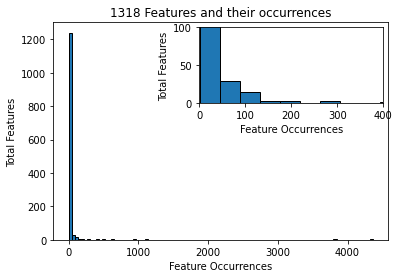

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

# Plot histogram
plt.hist(all_features.values(), bins=100, edgecolor='black')
plt.xlabel('Feature Occurrences')
plt.ylabel('Total Features')
plt.title(f'{len(all_features)} Features and their occurrences')

# Define the region of interest (bounding box)
x1, x2 = 0, 400  # Define the range of x-axis values for the zoomed-in plot
y1, y2 = 0, 100  # Define the range of y-axis values for the zoomed-in plot

# Get the current axes
ax = plt.gca()

# Create a new inset axes within the original plot
ax_zoom = inset_axes(ax, width="55%", height="35%", loc='upper right')

# Plot the zoomed-in histogram within the inset axes
ax_zoom.hist(all_features.values(), bins=100, edgecolor='black')
ax_zoom.set_xlim(x1, x2)
ax_zoom.set_ylim(y1, y2)
ax_zoom.set_xlabel('Feature Occurrences')
ax_zoom.set_ylabel('Total Features')

plt.show()

#### Highly skewed towards left
To qualify for company's main features, the expectation is that it should atleast occur in 1% of total companies 

In [10]:
# Selecting threshold for filtering features: 1% of total companies
threshold = round(0.01 * len(companies))
threshold

56

In [11]:
potential_features = dict(filter(lambda x:x[1]>threshold, list(all_features.items())))
len(potential_features)

66

In [12]:
irrelevant_features = dict(filter(lambda x:x[1]<=threshold, list(all_features.items())))
len(irrelevant_features)

1252

#### We will manually verify later if any important features went in the irrelevant_features category

In [13]:
# sorted(irrelevant_features, key=lambda x:irrelevant_features.get(x), reverse=True)

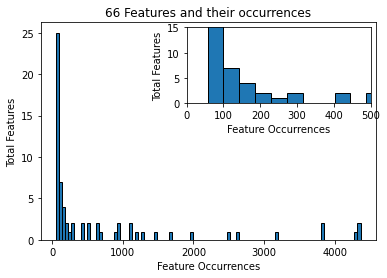

In [14]:
# Plot histogram
plt.hist(potential_features.values(), bins=100, edgecolor='black')
plt.xlabel('Feature Occurrences')
plt.ylabel('Total Features')
plt.title(f'{len(potential_features)} Features and their occurrences')

# Define the region of interest (bounding box)
x1, x2 = 0, 500  # Define the range of x-axis values for the zoomed-in plot
y1, y2 = 0, 15  # Define the range of y-axis values for the zoomed-in plot

# Get the current axes
ax = plt.gca()

# Create a new inset axes within the original plot
ax_zoom = inset_axes(ax, width="55%", height="35%", loc='upper right')

# Plot the zoomed-in histogram within the inset axes
ax_zoom.hist(potential_features.values(), bins=100, edgecolor='black')
ax_zoom.set_xlim(x1, x2)
ax_zoom.set_ylim(y1, y2)
ax_zoom.set_xlabel('Feature Occurrences')
ax_zoom.set_ylabel('Total Features')

plt.show()

#### Dividing 66 potential_features into two bucket, extra_features (less important) and selected_features (more relevant)

In [15]:
# Find the median, will use this to filter more features (which can be stored in `extra_features`)
median_value = np.median(list(potential_features.values()))
print("Median:", median_value)

Median: 169.5


In [16]:
selected_features = dict(filter(lambda x:x[1]>median_value, list(potential_features.items())))
len(selected_features)

33

In [17]:
extra_features = dict(filter(lambda x:x[1]<=median_value, list(potential_features.items())))
len(extra_features)

33

### Cleaning & Extracting selected_features

In [18]:
selected_features

{'Type': 3842,
 'Traded as': 1279,
 'Industry': 3818,
 'Founded': 4359,
 'Founders': 618,
 'Headquarters': 4366,
 'Area served': 1468,
 'Key people': 3196,
 'Products': 2627,
 'Revenue': 1966,
 'Parent': 1127,
 'Website': 4289,
 'Predecessor': 274,
 'Founder': 1678,
 'Fate': 408,
 'Location': 199,
 'Operating income': 946,
 'Net income': 1194,
 'Total assets': 1105,
 'Total equity': 944,
 'Number of employees': 2498,
 'Trade name': 271,
 'Formerly': 507,
 'Defunct': 419,
 'Successor': 185,
 'Owner': 674,
 'Services': 514,
 'Brands': 172,
 'Genre': 195,
 'Number of locations': 884,
 'Subsidiaries': 653,
 'Divisions': 287,
 'ISIN': 174}

In [19]:
registrantNameDomainPattern = re.compile(r"((?:[a-z0-9](?:[a-z0-9-]{0,61}[a-z0-9])?\.)+[a-z0-9][a-z0-9-]{0,61}[a-z])")

def clean_domain(url):
    # Remove leading "http://" or "https://"
    url = url.lower().strip('"').strip("'")
    if ' ' in url: 
        url = ''.join(url.split(' '))
    url = re.sub(r'.*http?s?://', '', url)
    # Remove leading "www."
    url = re.sub(r'.*www\.', '', url)
    # Remove any additional paths or parameters after the main domain
    url = re.sub(r'/.*$', '', url)
    # Remove any `.` in the end
    url = url.strip('.')
    # Remove any additional text after the top level domain
    url = re.sub(r'\.com.*$', '.com', url)
    url = re.sub(r'\.net.*$', '.net', url)
    url = re.sub(r'\.gov.*$', '.gov', url)
    url = re.sub(r'\.org.*$', '.org', url)
    url = re.sub(r'\.edu.*$', '.edu', url)
    url = re.sub(r'\.mil.*$', '.mil', url)
    # Remove any url that doesn't contain `.`
    url = '' if '.' not in url else url
    # Match the regex pattern
    match = registrantNameDomainPattern.search(url)
    url = match.group(1) if match else url
    return url

def clean_boxes(s):
    # Remove `[]`
    s = re.sub(r'\[\d\]', '', s)
    return s

def extract_year(text):
    match = re.search(r'\b\d{4}\b', text)
    return str(match.group()) if match else ''

In [20]:
clean_type = lambda x: [word.strip() for word in x.split(',') if re.findall(r'\b\w+ ?\b',re.sub(r'\(.*\)','',word))]
clean_parent = lambda x: [word.strip() for word in x.split(',') if re.findall(r'\b\w+ ?\b',re.sub(r'\(.*\)|\bLLC\b|\bInc.?\b|\bLtd.?\b|\band\b|\bIndependent\b','',word))]

clean_companies_with_selected_features = {}
for company_name in clean_companies.keys():
    company = clean_companies[company_name]
    temp = {}
    for key in company.keys():
        if key not in selected_features:
            continue
        items = []
        s = ''
        for item in company[key]:
            if key == 'Website':
                s += f'{item}' if item != '' else ' '
            elif key in ['Headquarters','Areas served', 'Area served', 'Number of locations', 'Total equity', 'Total assets', 'AUM',
                         'Net income', 'Operating income', 'Revenue', 'Traded as', 'Founded', 'Employees', 'Number of employees']:
                s += f' {item}' if item != '' else ' '
                s = clean_boxes(s)
            else:
                s += f'{item},' if item != '' else ' '
                s = clean_boxes(s)
            if s.strip() != '':
                if key == 'Website':
                    temp['Domain']=clean_domain(s.strip())
                elif key =='Founded':
                    temp['Founded']=extract_year(s.strip())
                elif key == 'Type':
                    temp['Type']=' '.join(clean_type(s.strip()))
                elif key == 'Parent':
                    temp['Parent']=clean_parent(s.strip())
                else:
                    temp[key]=[s.strip()]
        clean_companies_with_selected_features[company_name] = temp
    
len(clean_companies_with_selected_features)

4908

In [21]:
def combine_series_on_indexes_having_list_values(series1, series2):
    
    # Function to fill NaN values with empty lists
    def _fill_with_empty_list(x):
        return x if isinstance(x, list) else []

    # Function to fill NaN values with empty lists
    def _fill_empty_list_with_nan(x):
        return np.nan if x==[] else x

    # Function to combine the lists in Series 1 and Series 2
    def _combine_lists(x, y):
        if isinstance(x, list):
            return x + y
        elif isinstance(y, list):
            return y
        return []

    series1 = series1.apply(_fill_with_empty_list)
    series2 = series2.apply(_fill_with_empty_list)

    # Create Series 3 by applying the function
    series3 = series1.combine(series2, _combine_lists)
    series3 = series3.apply(_fill_empty_list_with_nan)
    return series3

In [22]:
df = pd.DataFrame(clean_companies_with_selected_features).T
df.shape

(4908, 33)

In [23]:
df['Traded as'] = df['Traded as'].dropna().apply(lambda x:','.join(x)).apply(lambda x:''.join(x.split(':')).strip())
df['Headquarters'] = df['Headquarters'].dropna().apply(lambda x:' '.join((','.join((' '.join(x)).split(' '))).split(',')))
df.loc[df['Founded']=='', 'Founded'] = np.nan

In [24]:
df['Founders'] = combine_series_on_indexes_having_list_values(df['Founders'], df['Founder'])
df['Key people'] = combine_series_on_indexes_having_list_values(df['Key people'], df['Owner'])
df['People'] = combine_series_on_indexes_having_list_values(df['Key people'], df['Founders'])
df.drop('Owner', axis=1, inplace=True)
df.drop('Founder', axis=1, inplace=True)
df.drop('Founders', axis=1, inplace=True)
df.drop('Key people', axis=1, inplace=True)

In [25]:
df['Industry'] = combine_series_on_indexes_having_list_values(df['Industry'], df['Genre'])
df.drop('Genre', axis=1, inplace=True)

In [26]:
df['Products_and_Services'] = combine_series_on_indexes_having_list_values(df['Products'], df['Services'])
df.drop('Products', axis=1, inplace=True)
df.drop('Services', axis=1, inplace=True)

In [27]:
df['Subsidiaries'] = combine_series_on_indexes_having_list_values(df['Subsidiaries'], df['Divisions'])
df.drop('Divisions', axis=1, inplace=True)

In [28]:
df['Aliases'] = combine_series_on_indexes_having_list_values(df['Successor'], df['Formerly'])
df['Aliases'] = combine_series_on_indexes_having_list_values(df['Trade name'], df['Aliases'])
df['Aliases'] = combine_series_on_indexes_having_list_values(df['Predecessor'], df['Aliases'])
df.drop('Successor', axis=1, inplace=True)
df.drop('Formerly', axis=1, inplace=True)
df.drop('Trade name', axis=1, inplace=True)
df.drop('Predecessor', axis=1, inplace=True)

In [29]:
df['Locations'] = combine_series_on_indexes_having_list_values(df['Number of locations'], df['Area served'])
df['Locations'] = combine_series_on_indexes_having_list_values(df['Locations'], df['Location'])
df.drop('Area served', axis=1, inplace=True)
df.drop('Number of locations', axis=1, inplace=True)
df.drop('Location', axis=1, inplace=True)

In [30]:
#df['is_defunct'] = np.nan
#df.loc[df['Defunct'].dropna().index]['is_defunct'] = True
#df.drop('Defunct', axis=1, inplace=True)

In [31]:
df["Fate"] = df["Fate"].dropna().apply(lambda x:' '.join(x[0].split(',')))

In [32]:
for col in ['Total equity', 'Total assets', 'Net income', 'Operating income', 'Revenue']:
    df[col] = df[col].dropna().apply(lambda x: x[0])

In [33]:
df.index = pd.Series(df.index.values).apply(lambda x:' '.join(x.split('_')))

In [34]:
df = df.dropna(how='all').dropna(how='all',axis=1)

In [35]:
df.shape

(4905, 22)

In [36]:
df

,Type,Traded as,Industry,Founded,Headquarters,Revenue,Parent,Domain,Fate,Operating income,...,Total equity,Number of employees,Defunct,Brands,Subsidiaries,ISIN,People,Products_and_Services,Aliases,Locations
EMC Corporation,Subsidiary,EMC,"[Computer storage,]",1979,Round Rock Texas United States,US$ 41.224 billion,[Dell Technologies],dell.com,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[Jeff Clarke,( ,Infrastructure Solutions Group...","[See EMC products,]",NaN,[Worldwide]
"IArchives, Inc.",Private subsidiary of Ancestry.com,NaN,"[Historical documents,]",1994,Lindon Utah United States,NaN,[Ancestry.com LLC],iarchives.com,Acquired,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[Brian Hansen, general manager, Scott Christen...",NaN,"[Automated Solutions, Inc.,]",[Worldwide]
The Kegs Drive-In,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[901 N 5th St,Grand Forks, North Dakota,]"
Vertica,NaN,NaN,"[Database management, Data warehousing,]",2005,Cambridge MA United States,NaN,[OpenText],vertica.com,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[Mark Barrenechea,( and ,, Andrew Palmer and M...","[Vertica Analytics Database, Vertica SQL on Da...",NaN,NaN
The Hartford,Public,HIG Component,"[Insurance,Mutual funds,]",1810,Hartford Connecticut U.S.,US$20.74 billion,NaN,thehartford.com,NaN,US$2.82 billion,...,US$16.27 billion,"[~19,500]",NaN,NaN,NaN,NaN,"[Christopher J. Swift,( & ,Beth A. Costello,(...","[Automobile insurance,Property insurance,Gener...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Buck Knives,Corporation,NaN,"[Manufacturing,]",1902,Post Falls Idaho,US$80 million,NaN,buckknives.com,NaN,NaN,...,NaN,[320],NaN,NaN,NaN,NaN,"[Hoyt Buck, Founder; Al Buck, former ; Chuck B...","[Knives,]",NaN,NaN
Life Fitness,Portfolio company,NaN,NaN,1977,Franklin Park Illinois,NaN,NaN,lifefitness.com,NaN,NaN,...,NaN,"[2,460]",NaN,"[Life Fitness,Hammer Strength,Cybex,Indoor Cyc...",NaN,NaN,"[Paul Stoneham ,, KPS Capital Partners,, Augie...",NaN,NaN,NaN
Telemundo,Free-to-air television network,NaN,NaN,1984,Miami Florida U.S.,NaN,"[NBCUniversal Telemundo Enterprises, NBCUniver...",telemundo.com,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[Beau Ferrari,( of NBCUniversal Telemundo Ent...",NaN,NaN,NaN
Crain Communications,Private,NaN,"[News, periodicals,]",1916,Detroit Michigan U.S.,NaN,NaN,crain.com,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[Keith Evans Crain, Christoper Crain,, Crain f...","[Advertising Age,Autoweek,Crain's Cleveland Bu...",NaN,NaN


In [37]:
df.columns

Index(['Type', 'Traded as', 'Industry', 'Founded', 'Headquarters', 'Revenue',
       'Parent', 'Domain', 'Fate', 'Operating income', 'Net income',
       'Total assets', 'Total equity', 'Number of employees', 'Defunct',
       'Brands', 'Subsidiaries', 'ISIN', 'People', 'Products_and_Services',
       'Aliases', 'Locations'],
      dtype='object')

In [40]:
df.describe().T

,count,unique,top,freq
Type,3840,558,Private,981
Traded as,1279,1221,YELL Component,4
Industry,3874,1883,"[Retail,]",212
Founded,4357,226,,140
Headquarters,4366,2986,Portland Oregon United States,27
Revenue,1966,1821,US$2.6 billion,5
Parent,1126,934,[FAT Brands],7
Domain,4265,3942,,176
Fate,408,349,Acquired,13
Operating income,945,874,$ 98 million,4


In [62]:
extra_features

{'Coordinates': 66,
 'AUM': 72,
 'Production output': 57,
 'Areas served': 80,
 'IATA': 121,
 'Hubs': 95,
 'Fleet size': 101,
 'Parent company': 111,
 'Area': 118,
 'Owners': 59,
 'Country': 167,
 'State': 113,
 'County': 90,
 'Government': 68,
 '•\xa0Total': 85,
 '•\xa0Land': 99,
 '•\xa0Water': 99,
 'Population': 101,
 '•\xa0Density': 98,
 'Time zone': 98,
 '•\xa0Summer ': 97,
 'Area code': 57,
 'FIPS code': 88,
 'Ceased operations': 60,
 'URL': 58,
 'Country of origin': 105,
 'Official website': 88,
 'Predecessors': 89,
 'Elevation': 71,
 'Destinations': 76,
 'Employees': 64,
 'Opened': 69,
 '': 58}

### Exploration

In [52]:
df['Founded'].value_counts()

1999    81
1996    79
1997    77
1993    66
1983    65
        ..
1826     1
1763     1
1819     1
1729     1
1802     1
Name: Founded, Length: 225, dtype: int64

In [ ]:
df['Headquarters']

In [ ]:
# Function to clean address components using regular expressions
def clean_address_components(components):
    if isinstance(components, list):
        cleaned_components = [re.sub(r'[^a-zA-Z0-9\s]', '', str(comp)).strip() for comp in components]
        cleaned_components = [comp for comp in cleaned_components if comp]
        return ', '.join(cleaned_components)
    else:
        
        return components

# Apply the cleaning function to the "Headquarter" column
df_cleaned["Headquarter"] = df_cleaned["Headquarters"].apply(clean_address_components)


In [ ]:
df["Net income"].dropna()

In [ ]:
collect = {}
for item in df['Headquarters'].dropna().apply(lambda x:x.split(' ')).values:
    for word in item:
        collect[word] = collect.get(word, 0) + 1

In [ ]:
collect

In [ ]:
clean_list = lambda x: [word.strip() for word in x.split(',') if re.findall(r'\b\w+ ?\b',re.sub(r'\(.*\)|\bLLC\b|\bInc.?\b|\bLtd.?\b|\band\b|\bIndependent\b','',word))]

temp = {}
col = 'Parent'
for company in clean_companies_with_selected_features.keys():
    content = clean_boxes(','.join(clean_companies_with_selected_features[company].get(col, [])))
    temp[company] = content

test = pd.DataFrame(temp, index=[col]).T.replace('', np.nan).dropna()[col].apply(lambda x:clean_list(x))
test.to_dict()

In [ ]:
test2 = pd.DataFrame(clean_companies_with_selected_features).T[['Domain']].replace('', np.nan).dropna()#.values.tolist()

In [ ]:
test3 = pd.concat([test, test2], axis=1)
test3


# test3.loc[test3['Domain'].isna()]['website'].tolist()

In [ ]:
output = {}

drop_columns = []
main_to_extra_cols = ['ISIN', 'AOC\xa0#', 'Ceased operations', 'Fleet size', 'Hubs', 'Defunct', 'Destinations', 'Production output']
extra_columns += main_to_extra_cols
main_columns = list(filter(lambda x: x not in main_to_extra_cols, main_columns))

for company_name in companies.keys():
    if company_name in skip_companies.union(companies_with_no_data):
        continue
    company = companies[company_name]
    main_columns_dict = {}
    extra_columns_dict = {}
    for key in company.keys():
        if key.find(".mw-parser") >= 0 or key.find(".plainlist") >= 0 or key in drop_columns:
            continue
        s = ''
        for item in company[key]:
            if item.find(".mw-parser") >= 0 or item.find(".plainlist") >= 0:
                continue
            if key =='Website':
                s += f'{item}' if item != '' else '\n'
                s = clean_domain(s)
            elif key =='Employees' or key=='Number of employees':
                s += f' {item}' if item != '' else '\n'
                s = clean_employees(s)
                s = clean_boxes(s)
            elif key =='Founded':
                s += f' {item}' if item != '' else '\n'
                s = extract_year(s)
            elif key in ['Headquarters','Areas served', 'Area served', 'Number of locations', 'Total equity', 'Total assets', 'AUM',
                         'Net income', 'Operating income', 'Revenue', 'Traded as', 'Type']:
                s += f' {item}' if item != '' else '\n'
                s = clean_boxes(s)
            else:
                s += f',{item}' if item != '' else '\n'
        if s.strip() != '' and key in main_columns:
            main_columns_dict[key]=[s.strip()]
        elif s.strip() != '' and key in extra_columns:
            extra_columns_dict[key]=[s.strip()]
    if extra_columns_dict:
        main_columns_dict['info']=extra_columns_dict
    output[company_name] = main_columns_dict